In [31]:
import torch
import torchvision
import os
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

In [2]:
os.chdir("../")
os.getcwd()

'/home/victor/Programming/fl_squared'

In [11]:
api = wandb.Api()
run = api.run("pydqn/rep-in-fed/qfb8r4ke")

In [12]:
data = run.history()

In [14]:
data["train_loss"] = data[[f"client{i}_train_loss" for i in range(10)]].mean(axis=1)

In [15]:
data["train_loss"]

0    1.953221
1    1.812462
2    1.639546
3    1.472773
4    1.304012
5    1.088129
6    0.726699
7    0.163397
8    0.052569
9    0.023029
Name: train_loss, dtype: float64

In [6]:
val_acc = data["val_acc"].to_numpy()
train_loss = data["train_loss"].to_numpy()

In [68]:
def get_run(run_id):
    run = api.run(f"pydqn/rep-in-fed/{run_id}")
    return run

def get_history(run: wandb.apis.public.Run, keys: list[str]):
    return run.scan_history(keys=keys)

def history_scan_to_df(history) -> dict:
    keys = history.keys
    arrays = {k: [] for k in keys}

    for d in history:
        for k, v in d.items():
            arrays[k].append(v)
    
    return pd.DataFrame(arrays)

@dataclass
class Curve:
    data: np.ndarray
    ylabel: str
    color: str

def plot_two_curves_in_one_graph(data1: Curve, data2: Curve, xlabel: str, title: str, save: bool=False, filename: str=None):
    if save == True and filename is None:
        raise(ValueError("Can't save figure without a filename"))
    x = range(len(data1.data))

    fig, ax1 = plt.subplots()

    color1 = data1.color
    color2 = data2.color

    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(data1.ylabel, color=color1)
    ax1.plot(x, data1.data, color=color1)
    ax1.tick_params(axis="y", labelcolor=color1)

    ax2 = ax1.twinx()
    ax2.set_ylabel(data2.ylabel, color=color2)
    ax2.plot(x, data2.data, color=color2)
    ax2.tick_params(axis="y", labelcolor=color2)

    plt.title(title)

    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

def plot_training_curve(run_path: str, title: str, fed: bool = False, save: bool=False, filename: str=None):
    run = get_run(run_path)
    # keys = ["val_acc"]
    keys = ["top1_val_acc"]
    client_loss_names = [f"client{i}_train_loss" for i in range(10)]
    if fed:
        keys.extend(client_loss_names)
        xlabel = "Rounds"
    else:
        keys.append("train_loss")
        xlabel = "Epochs"
    
    df = history_scan_to_df(get_history(run, keys))
    if fed:
        df["train_loss"] = df[client_loss_names].mean(axis=1)
    
    train_loss = df["train_loss"].to_numpy()
    # val_acc = df["val_acc"].to_numpy()
    val_acc = df["top1_val_acc"].to_numpy()

    curve1 = Curve(train_loss, "Train loss", "tab:red")
    curve2 = Curve(val_acc, "Validation accuracy", "tab:blue")

    plot_two_curves_in_one_graph(curve1, curve2, xlabel, title, save, filename)

        

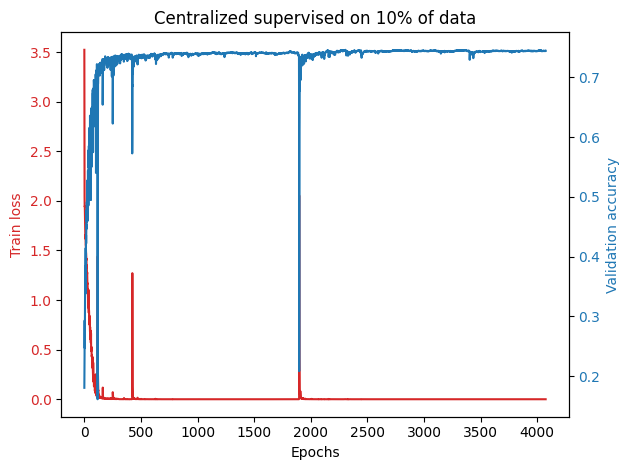

In [69]:
plot_training_curve("pydqn/rep-in-fed/si24fq59", "Centralized supervised on 10% of data", fed=False, save=True, filename="supervised_10th.png")